## Notes and ideas :
- look for the frequency of publication of articles.
#### Features to be included in the template:
- Images with more weighting than the body of the article ( they may contain more information and impact on the reader).
- Measure the degree of objectivity or subjectivity (using the Vader metric) of bbc news writers by calculating the average distance of a bbc article from neutralitypoint (this could be done by applying the prediction model on more various categories -hence more data injected) , input this into your main model.
- Count the number of authors and see if studying each author separately is efficient, knowing that no much writters write in the climate rubrique.
- A picture (if subjective) is worth a thousand words", but if it is not significant, i.e. objective, it has no impact, no matter how much we consider it, the final result will not be affected. so we multiply the picture text (not a thousand times ofc hhh) to ponder with the rest of the article content.
- study the sentiment of news about some emerging notion : metaverse (in cathefories and NER) maybe something else.
## Insight :
- Transfer learning is already applied, make sure in the insight that you offer a path to relearn the Vader program to articles similar to bbc news.  

In [161]:
import os
import csv
import json
import nltk
import spacy 
import shutil
import gcloud
import requests
import requests
import matplotlib
import numpy as np
import pandas as pd
import urllib.request
import networkx as nx
from PIL import Image
from spacy import displacy
from tqdm.notebook import *
from bs4 import BeautifulSoup
from itertools import groupby
from spacy.tokens import Span 
import matplotlib.pyplot as plt
from newsapi import NewsApiClient
from spacy.matcher import Matcher 
from matplotlib.pyplot import figure
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

!pip install spacy
!python -m spacy download en_core_web_sm
nltk.download('punkt')

# I- Fetching data :

Used to fetch news data using an original scrapper, including published images, so they be injected into the model as additional features  

In [162]:
def scrap_one_article(url, _, nbr_articles):
    try:
        dirName = 'images'
        os.mkdir(dirName)
    except:
        pass
    url_clean = url
    if url[6:19] == url[26:39]:
        url_clean = url[19:]
        print(url_clean)
    response = requests.get(url_clean)
    soup = BeautifulSoup(response.text, 'lxml')
    csv_file = open('bbc_news.csv', 'a')
    csv_writer = csv.writer(csv_file)
    author = 'BBC News'
    title = None
    csv_writer.writerow(['id', 'url', 'author', 'article_content','images descriptions'])
    try:
        author = soup.find_all(class_ = 'ssrcss-1rv0moy-Contributor')[0].find('strong').text[3:]
    except: #certain articles doesn't contain an element for the author
        pass
    try:
        title = soup.find_all(class_ = 'ssrcss-gcq6xq-StyledHeading')[0].text
    except: 
        pass
    try:
        date = soup.find_all(class_ = 'ecn1o5v2')[0].find('time')['datetime'][:10]
    except: 
        date = None
    Content_list = soup.find_all(class_ = 'eq5iqo00')
    article_content = build_text(Content_list)
    Images_descriptions = download_images_description(soup)
    article_dic= {'id': _ ,'url': url_clean,'author':author,'date': date,'title':title,'article_content':article_content, 'Image count': len(Images_descriptions), 'images descriptions':Images_descriptions}
    return article_dic

In [163]:
response = requests.get('https://www.bbc.com/news/uk-scotland-north-east-orkney-shetland-59517776')
soup = BeautifulSoup(response.text, 'lxml')

soup.find_all(class_ = 'ecn1o5v2')[0].find('time')['datetime'][:10]

'2021-12-03'

In [164]:
def build_text(list_):
    list_.pop()
    return '\n'.join([x.text for x in list_])
def dl_img(url, file_path, file_name):
    full_path = file_path + file_name + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    return full_path
def download_images(soup_result,article_index,nbr_articles):
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['src'] for res in soup_result.find_all('img')][-12:]
    print(len(img_results))
    for _ in tqdm (range(1,len(img_results))):
        image_link = img_results[_]
        image_link_loc = f'images/Article{article_index}/'
        file_name = f'img{_}'
        try:
            image_link_local = dl_img(image_link,image_link_loc, file_name)
            i += 1
            nbr_img+=1
        except:
            pass
        return nbr_img
def download_images_description(soup_result):
    nbr_img = 0
    try:
        os.mkdir(f'images/Article{article_index}')
    except:
        pass
    img_results = [res['alt'] for res in soup_result.find_all('img')][-12:]
    img_results
    return img_results
def get_links_list(soup):
        results = soup.find_all('a',class_ = 'gs-c-promo-heading')
        links_list = ['http://www.bbc.com/'+res['href'] if (res['href'][6:19] != res['href'][26:39]) else res['href'] for res in results]
        return links_list


In [165]:
def scrap_bbc_articles(category_url):
    try:    
        shutil.rmtree('images') 
    except:
        pass
    url = category_url
    response = requests.get(url)
    print('Request status (200 means a succesful request): ',response.status_code)
    soup = BeautifulSoup(response.text, 'lxml')
    links = get_links_list(soup)
    print('fetching begun ...')
    try: 
        csv_file = open('bbc_news.csv', 'a')
        print('Csv file created under the name bbc_news.csv')
    except: 
        pass
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['id', 'link', 'Author', 'Article content', 'publishing date','images count','images descriptions' ])
    print('Fetching data from ',len(links) - 5 ,' bbc news articles')
    results = []
    print('------------------------------------')

    for _ in tqdm(range(1,len(links)-5), desc = 'Fetching articles'):  # Covers all the articles len(links)+1
        try: 
            A = scrap_one_article(links[_], _, len(links))
            results.append(A)
        except:
            pass
    csv_file.close()
    return results


In [166]:
climate_url = 'https://www.bbc.com/news/science-environment-56837908'
data = scrap_bbc_articles(climate_url)
def fetch_clean_data(data_list): 
    article_results = [] 
    for i in range(len(data_list)):
        try:
            article_dict = {}
            article_dict['id'] = data_list[i]['id']
            article_dict['author'] = data_list[i]['author']
            article_dict['title'] = data_list[i]['title']
            article_dict['Publish date'] = data_list[i]['date']
            article_dict['url'] = data_list[i]['url']
            article_dict['article_content'] = data_list[i]['article_content'].strip("\n").strip("\t")
            article_dict['images descriptions'] = data_list[i]['images descriptions']
            article_results.append(article_dict)
        except IndexError:
            pass
    return article_results

Request status (200 means a succesful request):  200
fetching begun ...
Csv file created under the name bbc_news.csv
Fetching data from  38  bbc news articles
------------------------------------


https://www.bbc.com/future/article/20211208-how-to-make-diy-gifts-that-children-will-love
https://www.bbc.com/worklife/article/20211213-why-some-people-are-great-at-giving-gifts



In [167]:
Data = pd.DataFrame.from_dict(fetch_clean_data(data))
pd.set_option('max_colwidth', 500)
pd.set_option('max_colwidth', 100)

Data.head()

id                          author  \
0   1                  Kayleen Devlin   
1   2                        BBC News   
2   3                      athan Amos   
3   4                        BBC News   
4   5  Esme Stallard and Wanyuan Song   

                                                              title  \
0  The teenagers and the nun trying to stop an Australian coal mine   
1                 Arctic heat record is like Mediterranean, says UN   
2           Thwaites: Antarctic glacier heading for dramatic change   
3            Climate change: Four cheap ways to save energy at home   
4           Indonesia's biodiesel drive is leading to deforestation   

  Publish date                                                    url  \
0   2021-12-15      http://www.bbc.com//news/world-australia-59390798   
1   2021-12-14  http://www.bbc.com//news/science-environment-59649066   
2         None  http://www.bbc.com//news/science-environment-59644494   
3   2021-12-10  http://www.bbc.com//news/science-environment-58913875   
4   2021-12-08                      http://www.bbc.com//news/59387191   

                                                                                       article_content  \
0  When eight teenagers and an elderly nun in Australia teamed up for a climate case, they won, in ...   
1  The highest temperature ever recorded in the Arctic, 38C (100F), has been officially confirmed, ...   
2  Scientists are warning of dramatic changes at one of the biggest glaciers in Antarctica, potenti...   
3  Making your home more energy efficient can be costly and may not be possible if you're renting, ...   
4  Indonesia pledged at the recent COP26 climate summit that its greenhouse gas emissions would pea...   

                                                                                   images descriptions  
0  [Australia is the world's second largest exporter of coal, Victims of the Channel migrants trage...  
1  [line, Victims of the Channel migrants tragedy, Ghislaine Maxwell and Jeffrey Epstein, Virus, Ch...  
2  [Boaty McBoatface, Victims of the Channel migrants tragedy, Ghislaine Maxwell and Jeffrey Epstei...  
3  [Short presentational grey line, Victims of the Channel migrants tragedy, Ghislaine Maxwell and ...  
4  [Reality Check branding, Victims of the Channel migrants tragedy, Ghislaine Maxwell and Jeffrey ...

In [168]:
Data.to_csv('exported_bbc_data.csv')
Data.to_excel('exported_bbc_data.xlsx')

<h1> II- Data preprocessing :</h1>

### 2.1 Introduction
Feature engineering is an important process in the pipeline of any machine learning project.
It involves applying a series of transformations to the data, including
data, including eliminating bad records, encoding variables, scaling variables and finally eliminating
scaling of variables and finally the elimination of variables with a high correlation.
The motivation behind this process is to feed the algorithms with digested data
and to improve their performance by reducing the learning time.
In this project, different data processing techniques were applied to implement the machine learning models.
the machine learning models and improve their performance, which we will discuss below.
we will discuss below.
### 2.2 Missing value rate and zero variance
Here we try to eliminate variables with a very high rate of missing values
or zero variance. The following variables are then removed from our final database

In [169]:
Data.columns

Index(['id', 'author', 'title', 'Publish date', 'url', 'article_content',
       'images descriptions'],
      dtype='object')

In [170]:
def clean(Data):
    #lower case all content
    Data['article_content'] = Data["article_content"].map(lambda x: x.lower()) 
    #removing punctuation
    punc = '!()-[]{};:"\,<>./?@#$%^&*_~'
    def strip_punc(text):
        for ele in text:
            if ele in punc:
                text = text.replace(ele, "")                                                   
        return text
    Data['article_content'] = Data["article_content"].map(lambda x: strip_punc(x)) #lower case all content
    Data["Publish date"].fillna( method ='ffill', inplace = True) # Fill NaN values
clean(Data)
Data.head()

id                          author  \
0   1                  Kayleen Devlin   
1   2                        BBC News   
2   3                      athan Amos   
3   4                        BBC News   
4   5  Esme Stallard and Wanyuan Song   

                                                              title  \
0  The teenagers and the nun trying to stop an Australian coal mine   
1                 Arctic heat record is like Mediterranean, says UN   
2           Thwaites: Antarctic glacier heading for dramatic change   
3            Climate change: Four cheap ways to save energy at home   
4           Indonesia's biodiesel drive is leading to deforestation   

  Publish date                                                    url  \
0   2021-12-15      http://www.bbc.com//news/world-australia-59390798   
1   2021-12-14  http://www.bbc.com//news/science-environment-59649066   
2   2021-12-14  http://www.bbc.com//news/science-environment-59644494   
3   2021-12-10  http://www.bbc.com//news/science-environment-58913875   
4   2021-12-08                      http://www.bbc.com//news/59387191   

                                                                                       article_content  \
0  when eight teenagers and an elderly nun in australia teamed up for a climate case they won in a ...   
1  the highest temperature ever recorded in the arctic 38c 100f has been officially confirmed sound...   
2  scientists are warning of dramatic changes at one of the biggest glaciers in antarctica potentia...   
3  making your home more energy efficient can be costly and may not be possible if you're renting o...   
4  indonesia pledged at the recent cop26 climate summit that its greenhouse gas emissions would pea...   

                                                                                   images descriptions  
0  [Australia is the world's second largest exporter of coal, Victims of the Channel migrants trage...  
1  [line, Victims of the Channel migrants tragedy, Ghislaine Maxwell and Jeffrey Epstein, Virus, Ch...  
2  [Boaty McBoatface, Victims of the Channel migrants tragedy, Ghislaine Maxwell and Jeffrey Epstei...  
3  [Short presentational grey line, Victims of the Channel migrants tragedy, Ghislaine Maxwell and ...  
4  [Reality Check branding, Victims of the Channel migrants tragedy, Ghislaine Maxwell and Jeffrey ...

### 2.3 NER : Named entities recognition :
As it is part of the task, we are asked to display sentiment analysis for each NER.
the aim of this sub-section is to try differnet Nlp models to get NERs from text.
#### 2.3.1  Standford Ner :

Installation and Configuration: https://medium.com/manash-en-blog/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a

Stanford link: https://nlp.stanford.edu/software/CRF-NER.html

In [171]:
str_ = str(Data.iloc[5]['article_content']) # Article sample
str_[:200]

"it's a glorious autumn afternoon and i'm standing on a hillside looking out over tokyo bay beside me is takao saiki a usually mildmannered gentleman in his 70s\nbut today saikisan is angry\nit's a total"

In [172]:
model = "C:/Users/oussama/Desktop/nltk_standford/stanford-ner-2020-11-17/classifiers/english.all.3class.distsim.crf.ser.gz"
jar = "C:/Users/oussama/Desktop/nltk_standford/stanford-ner-2020-11-17/stanford-ner.jar"
st = StanfordNERTagger(model, jar,encoding='utf-8')
java_path = "C:/Program Files/Java/jdk-17.0.1/bin/java.exe" 
os.environ["JAVAHOME"] = java_path
tokenized_text = nltk.word_tokenize(str_)
classified_text = st.tag(tokenized_text)
netagged_words = classified_text
entities = []
labels = []
for tag, chunk in groupby(classified_text, lambda x:x[1]):
    if tag != "O":
        entities.append(' '.join(w for w, t in chunk))
        labels.append(tag)
entities_all = list(zip(entities, labels))
entities_unique = list(set(zip(entities, labels))) #unique entities   
data_entities_1 = pd.DataFrame(entities_unique)
data_entities_1.columns = ["Entities", "Labels"]
data_entities_1


Entities    Labels
0  australia  LOCATION
1      japan  LOCATION

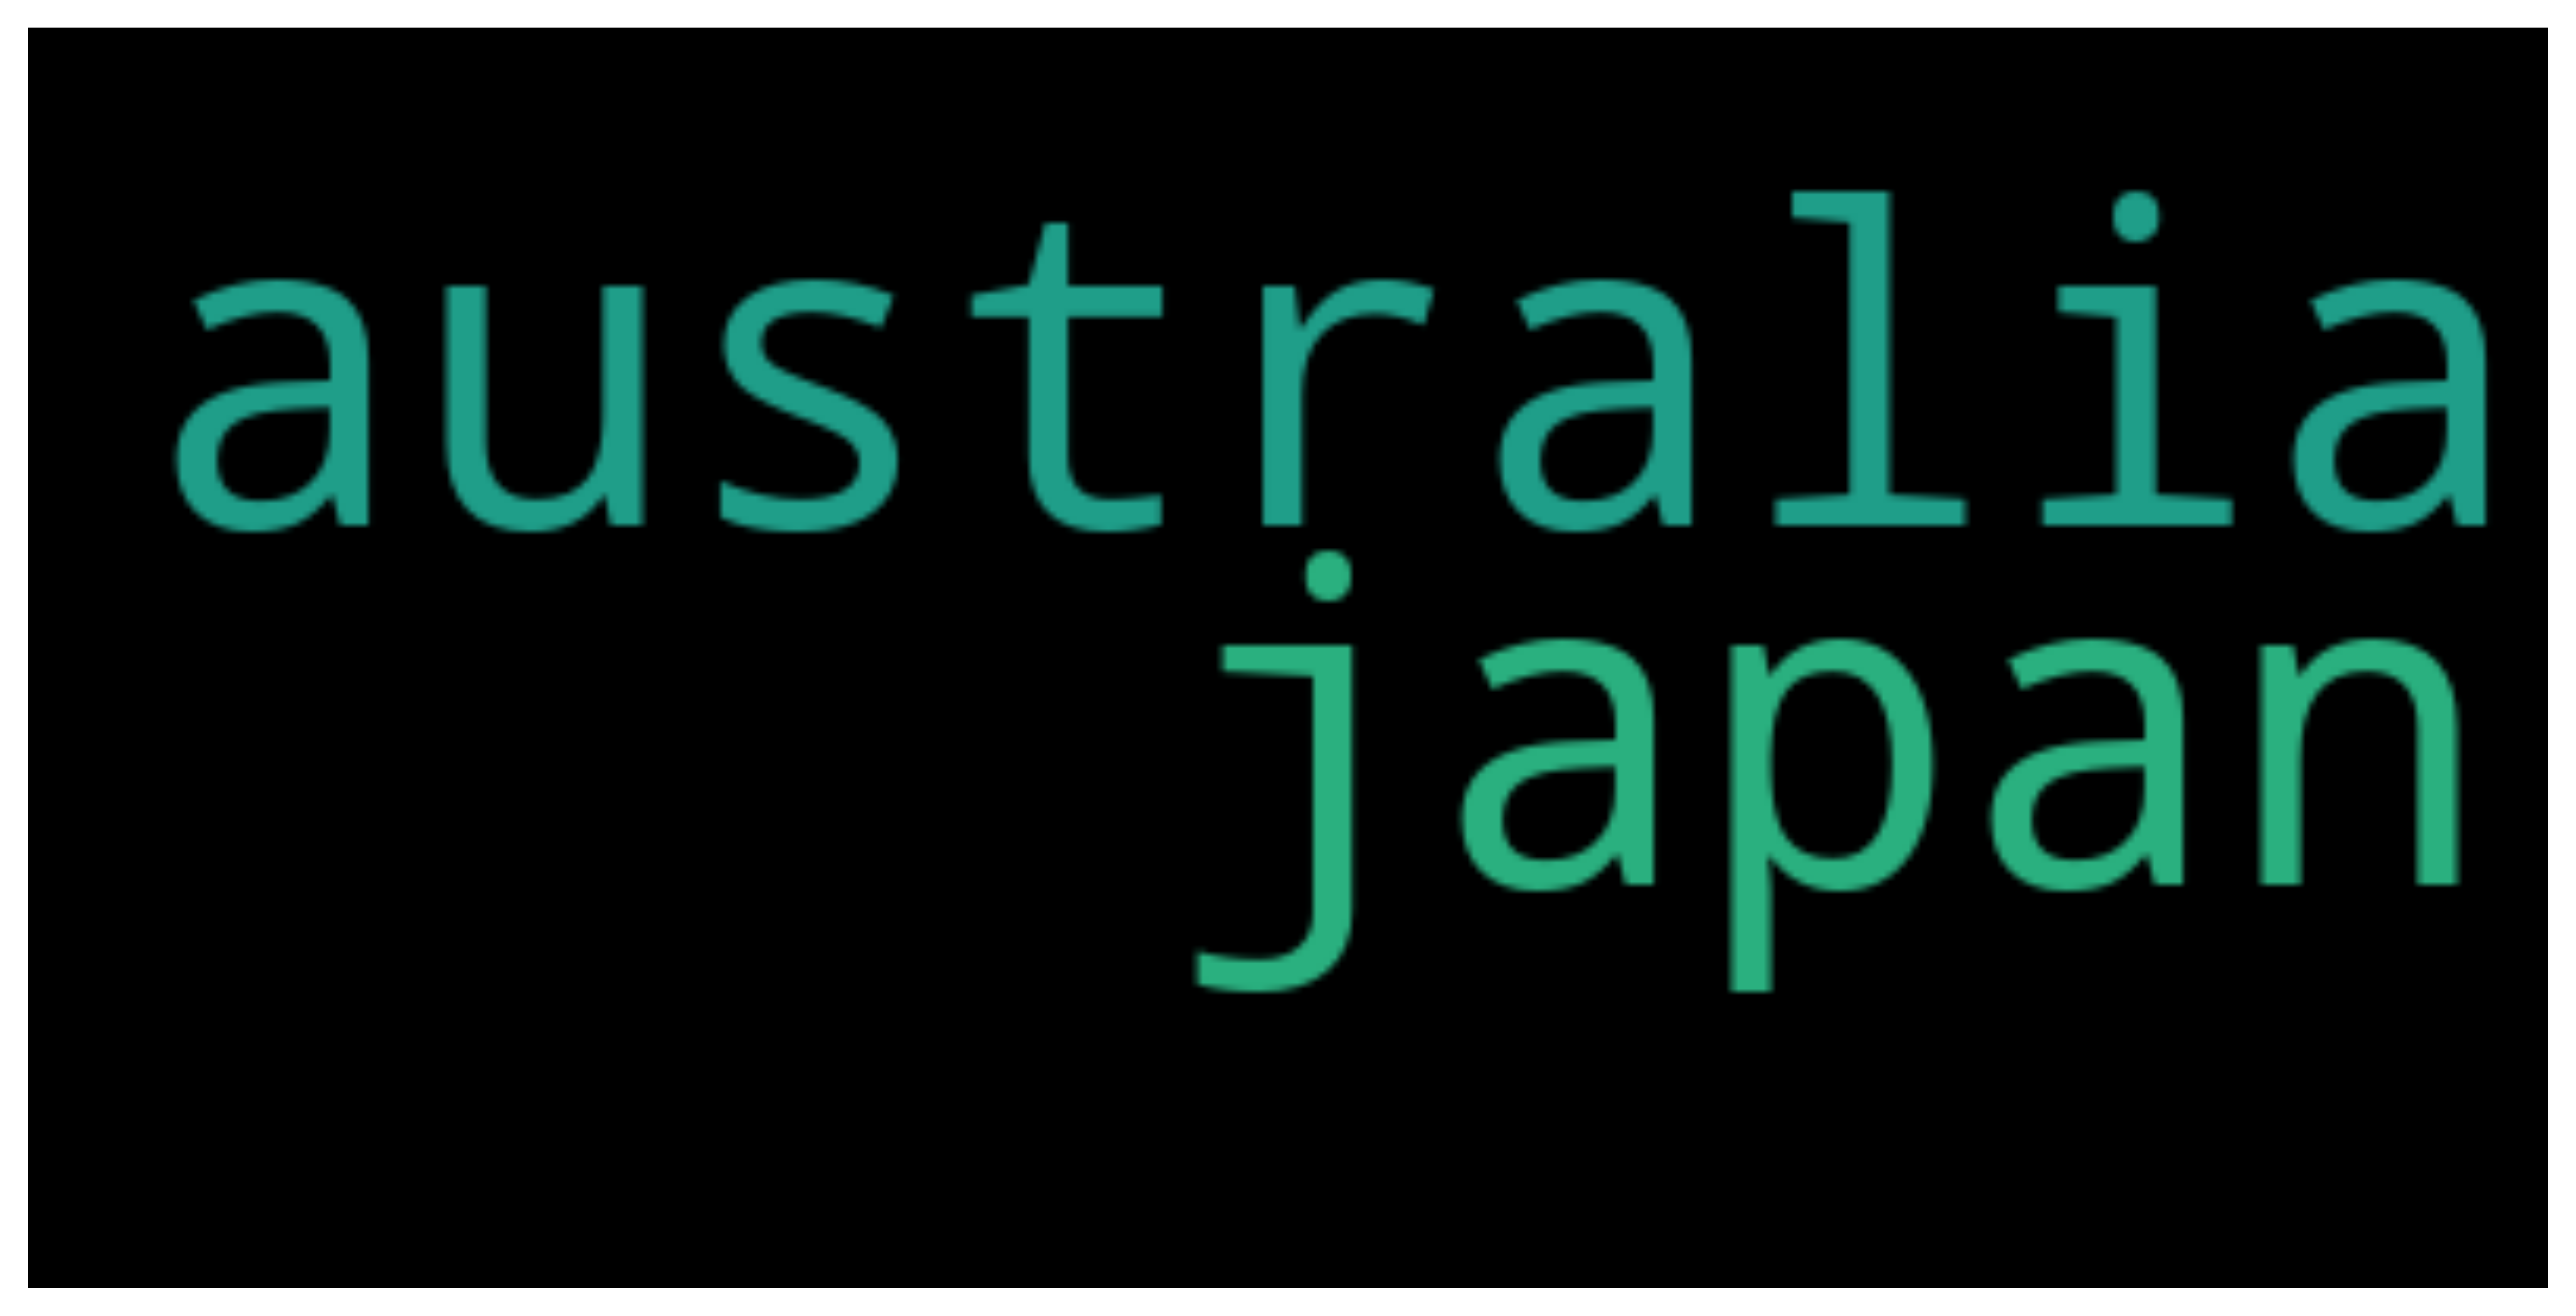

In [173]:
#illustration of NER words
text = ' '.join(data_entities_1['Entities'].to_list()) 
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(1000)
plt.show()

#### 2.3.2 Scapy :
`pip install cloudword`

Link: https://spacy.io/

In [179]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(str_)
entities = []
labels = []
position_start = []
position_end = []
for ent in doc.ents:
    entities.append(ent)
    labels.append(ent.label_)
    position_start.append(ent.start_char)
    position_end.append(ent.end_char)
data_entities_2 = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})
data_entities_2.head()

Entities    Labels  Position_Start  \
0                                 (70s)      DATE             156   
1                               (today)      DATE             164   
2                             (english)  LANGUAGE             225   
3  (more, than, seven, million, tonnes)  CARDINAL             527   
4                         (every, year)      DATE             576   

   Position_End  
0           159  
1           169  
2           232  
3           557  
4           586

##### Cleaning entities list: 
This would be by dropping unuasable N.E.

In [175]:
#fetch the list of named entities categories 
data_entities_2.Labels.unique()

array(['DATE', 'LANGUAGE', 'CARDINAL', 'GPE', 'NORP', 'ORDINAL', 'ORG',
       'PERSON', 'PRODUCT'], dtype=object)

In [176]:
data_entities_2.drop(data_entities_2.loc[data_entities_2['Labels'] == 'CARDINAL'].index, inplace=True)
data_entities_2.drop(data_entities_2.loc[data_entities_2['Labels'] == 'DATE'].index, inplace=True)
data_entities_2.Labels.unique()

array(['LANGUAGE', 'GPE', 'NORP', 'ORDINAL', 'ORG', 'PERSON', 'PRODUCT'],
      dtype=object)

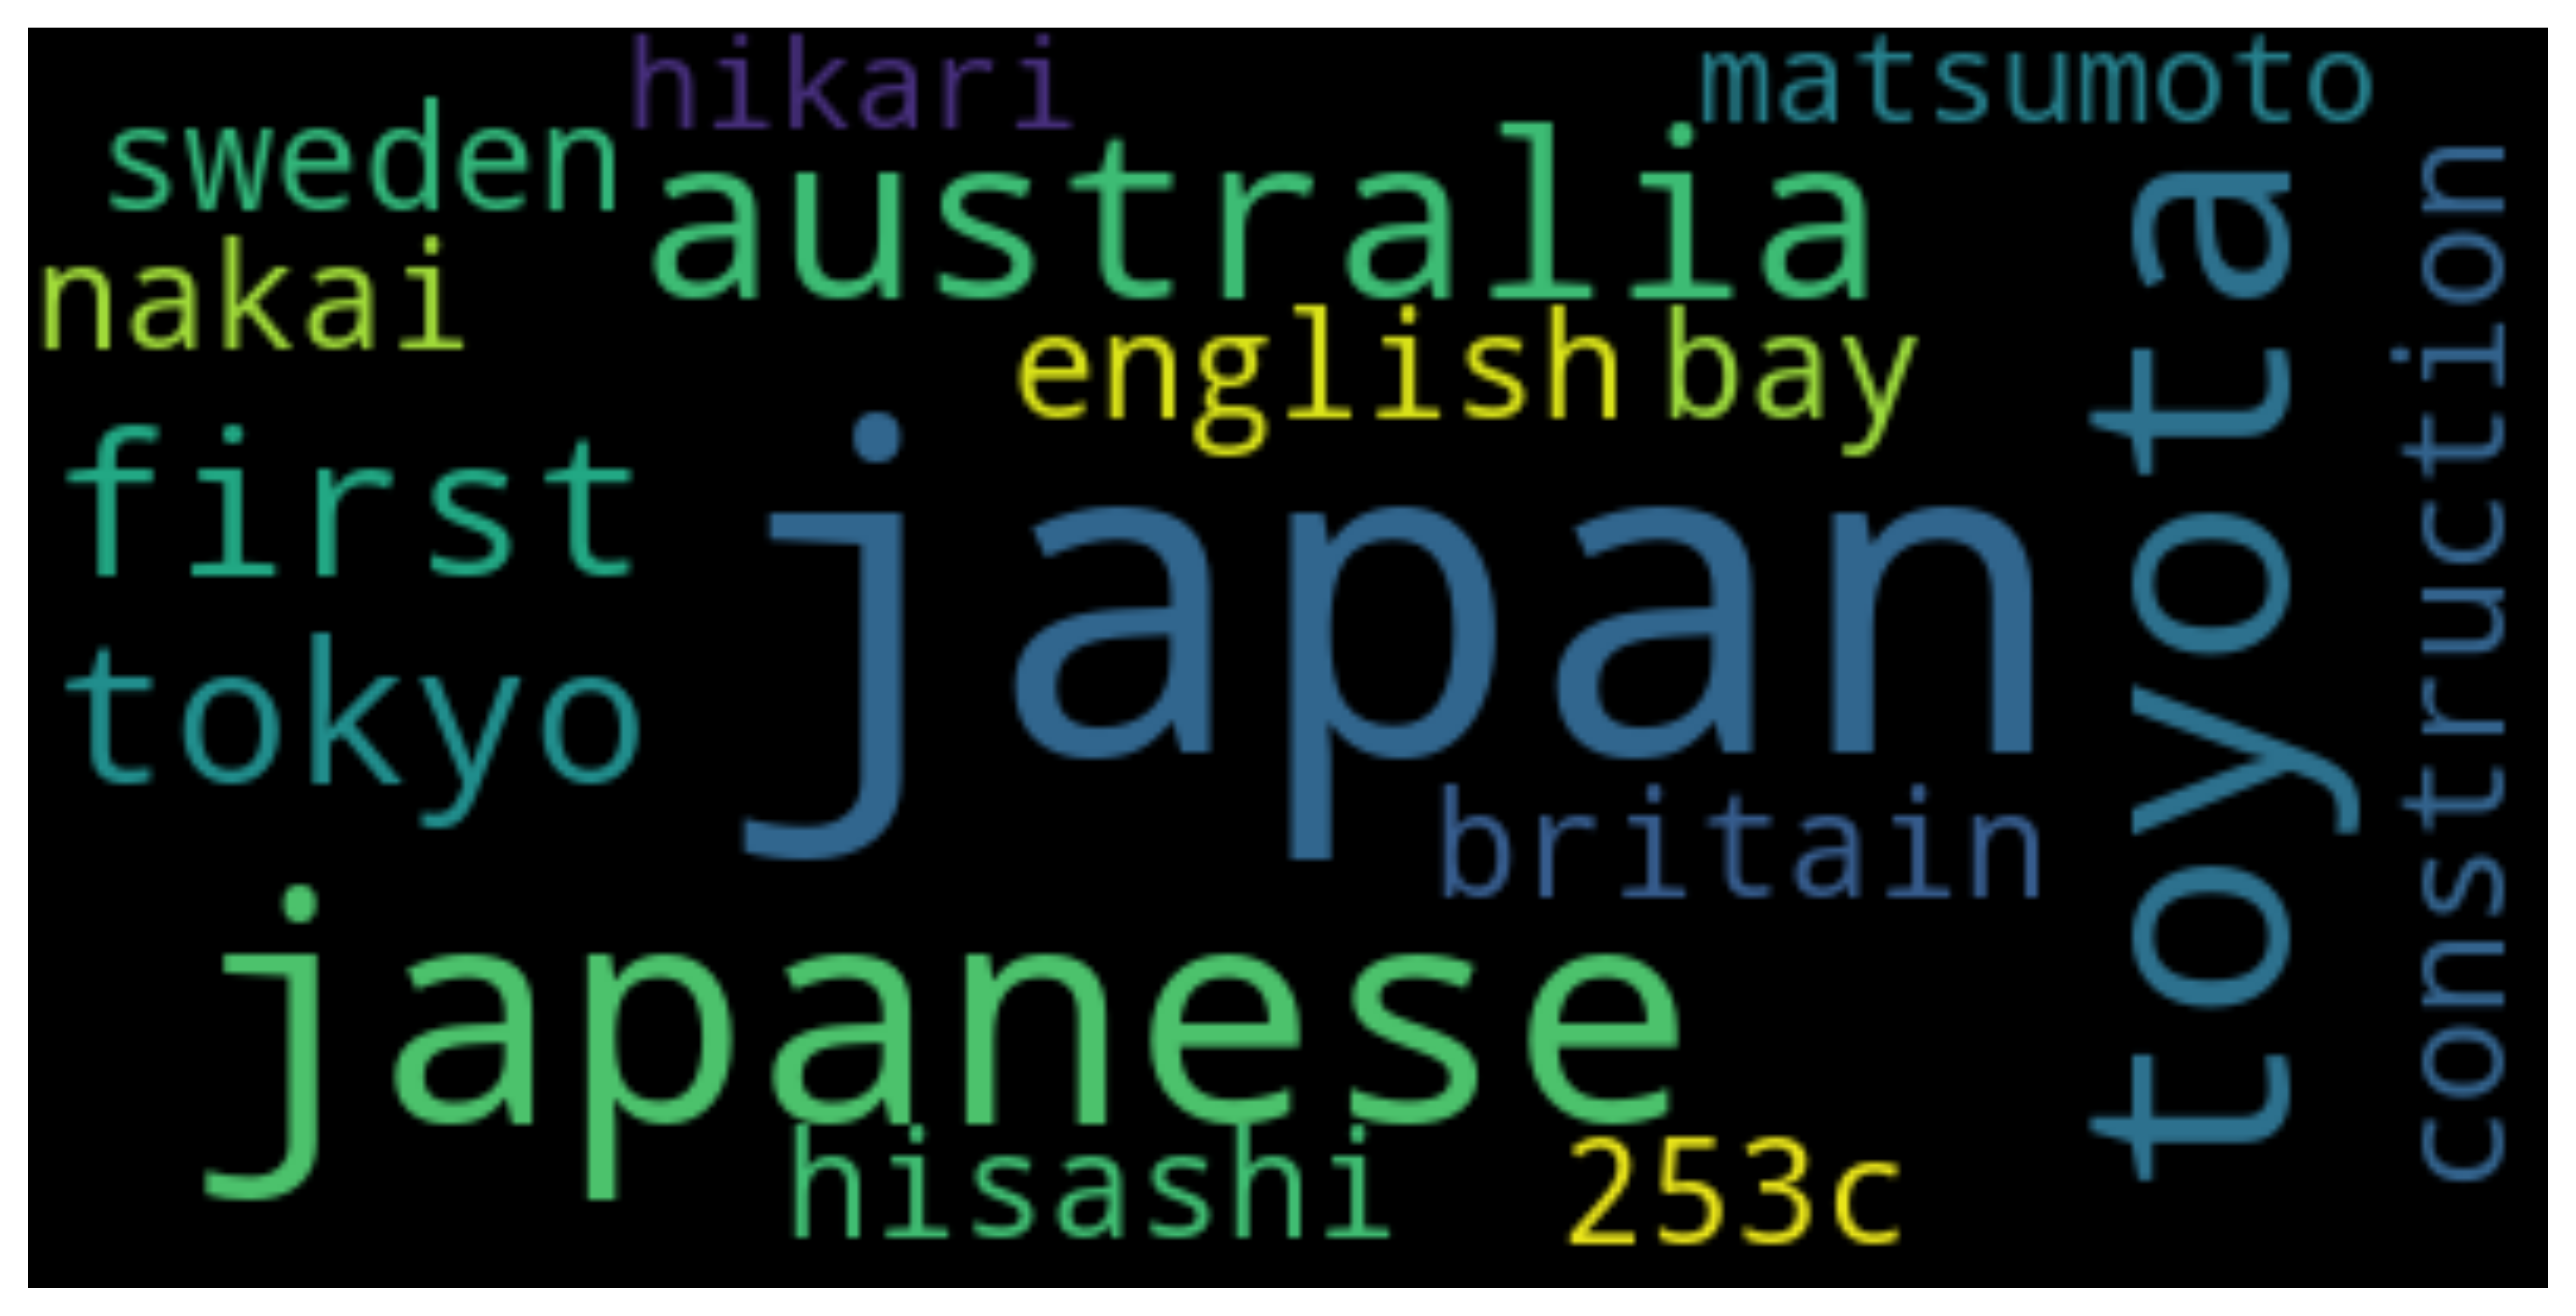

In [177]:
#illustration of NER words, might give a general idea
text = ' '.join([str(i) for i in data_entities_2['Entities'].to_list()])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 6)
fig.set_dpi(1000)
plt.show()


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

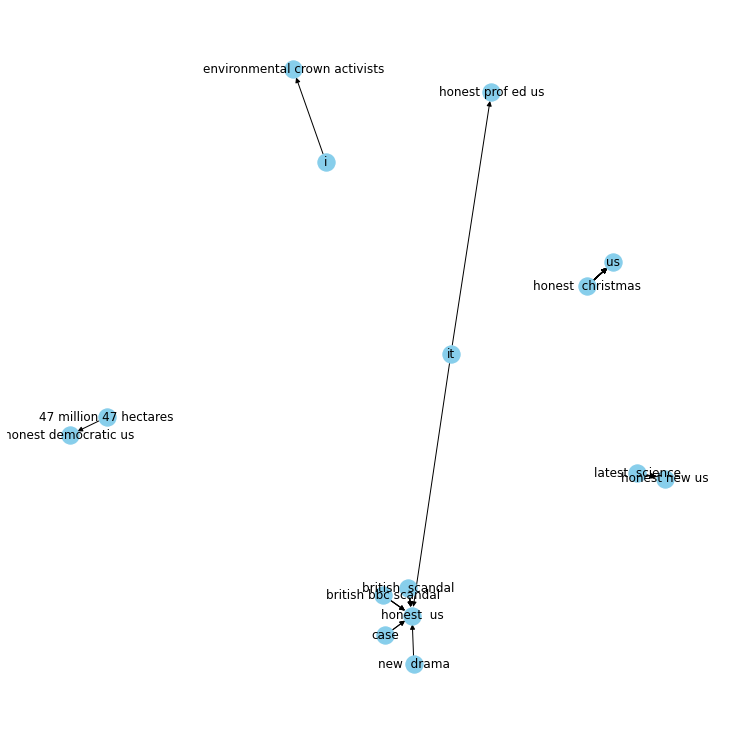